In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import os
import re
import string

# For reproducibility
from tensorflow import set_random_seed
from numpy.random import seed
seed(1)
set_random_seed(2)

# Deep Neural Network Sentiment Analysis Modeling 

Three Classes: Negative, Positive and Kudos. Collected all Kudos responses going back to November 2017.

In [11]:
train = pd.read_csv(r"Patient Reviews2.csv", encoding = 'unicode_escape')
train = train.fillna('')
train["text"] = train["Likelihood to Recommend Reason"] + ". " + train["Additional comments"]
train = train[["text","label"]]

In [12]:
train['label'].value_counts()

1    4292
0    4243
2    2020
Name: label, dtype: int64

In [82]:
train['label'].replace(1, 'Positive',inplace=True)
train['label'].replace(0, 'Negative',inplace=True)
train['label'].replace(2, 'Kudos',inplace=True)

In [6]:
train['label'].value_counts()

1    4292
0    4243
2    2020
Name: label, dtype: int64

## Tokenization

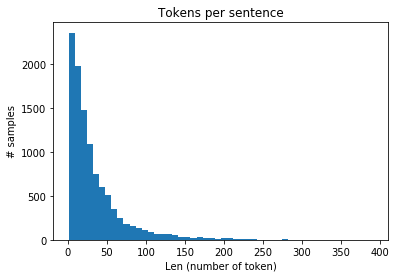

In [10]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in train['text'].values], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [13]:
imdb_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
imdb_tokenizer.fit_on_texts(train['text'].values)

x_train_seq = imdb_tokenizer.texts_to_sequences(train['text'].values)
#x_val_seq = imdb_tokenizer.texts_to_sequences(val['text'].values)

x_train = sequence.pad_sequences(x_train_seq, maxlen=MAX_LEN, padding="post", value=0)
#x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

encoder = LabelBinarizer()
encoder.fit(train['label'])
y_train = encoder.transform(train['label'])

print('First sample before preprocessing: \n', train['text'].values[0], '\n')
print('First sample after preprocessing: \n', x_train[0])

First sample before preprocessing: 
 . I appreciated the Technition who worked with me.  Great job! 

First sample after preprocessing: 
 [   3  334    1 1870   43  467   20   10   44  215    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [8]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

## Upsampling minority class of imbalanced dataset using Synthetic Minority Oversampling Technique aka SMOTE

In [9]:
import imblearn
from imblearn.over_sampling import SMOTE
## Importing resample
from sklearn.utils import resample
smote = SMOTE('minority')

X_sm, y_sm = smote.fit_sample(x_train, y_train)
print(X_sm.shape, y_sm.shape)

(12827, 90) (12827, 3)


In [10]:
y_sm

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

## Activation Function

## Architecture

In [8]:
BATCH_SIZE = 32
EPOCHS = 20
VOCAB_SIZE = 20000
MAX_LEN = 90
EMBEDDING_DIM = 40

In [9]:
# Model Parameters - You can play with these

NUM_FILTERS = 250
KERNEL_SIZE = 3
HIDDEN_DIMS = 250

In [9]:
# CNN Model
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into EMBEDDING_DIM dimensions
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn NUM_FILTERS filters
model.add(Conv1D(NUM_FILTERS,
                 KERNEL_SIZE,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(HIDDEN_DIMS))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We change output layer into softmax function
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 40)            800000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 40)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 88, 250)           30250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0     

In [41]:
model.fit(X_sm, y_sm,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1,
          verbose=2)

Train on 11544 samples, validate on 1283 samples
Epoch 1/3
 - 274s - loss: 0.3793 - acc: 0.8244 - val_loss: 0.4309 - val_acc: 0.8119
Epoch 2/3
 - 271s - loss: 0.1955 - acc: 0.9243 - val_loss: 0.6163 - val_acc: 0.7303
Epoch 3/3
 - 271s - loss: 0.1296 - acc: 0.9534 - val_loss: 0.4829 - val_acc: 0.8088


In [26]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
mcp_save = ModelCheckpoint('sentiment1.h5', save_best_only=True, monitor='val_loss', mode='min')
ReduceLR= ReduceLROnPlateau(monitor='val_loss', factor=0.75, verbose=1, mode='min',min_lr=0.0001)
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1,
          callbacks=[mcp_save, ReduceLR],
          verbose=2)

Train on 9499 samples, validate on 1056 samples
Epoch 1/5
 - 245s - loss: 0.5778 - acc: 0.7775 - val_loss: 1.6757 - val_acc: 0.0028
Epoch 2/5
 - 242s - loss: 0.2798 - acc: 0.8953 - val_loss: 0.6872 - val_acc: 0.7405
Epoch 3/5
 - 237s - loss: 0.1655 - acc: 0.9415 - val_loss: 0.6324 - val_acc: 0.7756
Epoch 4/5
 - 232s - loss: 0.1103 - acc: 0.9644 - val_loss: 0.9636 - val_acc: 0.6932
Epoch 5/5
 - 239s - loss: 0.0806 - acc: 0.9733 - val_loss: 0.9178 - val_acc: 0.6809


In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
mcp_save = ModelCheckpoint('sentiment2.h5', save_best_only=True, monitor='val_loss', mode='min')
ReduceLR= ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=1, mode='min',min_lr=0.0001)
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1,
          callbacks=[mcp_save, ReduceLR],
          verbose=2)

Train on 9499 samples, validate on 1056 samples
Epoch 1/20
 - 224s - loss: 0.5485 - acc: 0.7919 - val_loss: 1.2323 - val_acc: 0.3797
Epoch 2/20
 - 221s - loss: 0.2720 - acc: 0.8998 - val_loss: 0.5290 - val_acc: 0.8286
Epoch 3/20
 - 221s - loss: 0.1640 - acc: 0.9442 - val_loss: 0.6546 - val_acc: 0.7576
Epoch 4/20
 - 218s - loss: 0.1120 - acc: 0.9645 - val_loss: 0.8302 - val_acc: 0.6941
Epoch 5/20
 - 221s - loss: 0.0732 - acc: 0.9765 - val_loss: 1.5504 - val_acc: 0.5597
Epoch 6/20
 - 223s - loss: 0.0547 - acc: 0.9829 - val_loss: 1.1060 - val_acc: 0.6799
Epoch 7/20
 - 241s - loss: 0.0434 - acc: 0.9874 - val_loss: 1.3764 - val_acc: 0.6250

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Epoch 8/20
 - 224s - loss: 0.0286 - acc: 0.9918 - val_loss: 1.6238 - val_acc: 0.5900
Epoch 9/20
 - 236s - loss: 0.0216 - acc: 0.9944 - val_loss: 2.4058 - val_acc: 0.4962
Epoch 10/20


# Validation and Testing

In [49]:
val = pd.read_csv(r"Sentiment Test.csv", encoding = 'unicode_escape')
val = val.fillna('')
# append the positive and negative text reviews
val["text"] = val["Likelihood to Recommend Reason"] + ". " + val["Additional comments"]
# create the label
#reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 3 else 0)
# select only relevant columns
val = val[["text","label"]]

In [51]:
x_val_seq = imdb_tokenizer.texts_to_sequences(val['text'].values)
x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

encoder.fit(val['label'])
y_test = encoder.transform(val['label'])

In [ ]:
y_softmax = model.predict_classes(x_val)

In [44]:
val['Sentiment'] = y_softmax

In [14]:
from keras.models import load_model
model = load_model('sentiment2.h5')

In [15]:
test = pd.read_csv(r"test3.csv", encoding = 'unicode_escape')
test = test.fillna('')
# append the positive and negative text reviews
test["text"] = test["Likelihood to Recommend Reason"] + ". " + test["Additional comments"]
# create the label
#reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 3 else 0)
# select only relevant columns
test = test[["text"]]

In [16]:
test.head()

,text
0,My impression of the ultrasound tech and immed...
1,Easy to schedule appointments. Friendly. Effic...
2,Sensitive and thoughtful care.. Sensitive and ...
3,The two receptionists were very friendly- atte...
4,Techs always very personable and helpful. Wa...


In [17]:
x_test_seq = imdb_tokenizer.texts_to_sequences(test['text'].values)
x_test = sequence.pad_sequences(x_test_seq, maxlen=MAX_LEN, padding="post", value=0)

In [18]:
y_pred = model.predict_classes(x_test)

In [19]:
y_pred

array([2, 2, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,

In [20]:
test['Sentiment'] = y_pred

In [21]:
test

,text,Sentiment
0,My impression of the ultrasound tech and immed...,2
1,Easy to schedule appointments. Friendly. Effic...,2
2,Sensitive and thoughtful care.. Sensitive and ...,2
3,The two receptionists were very friendly- atte...,0
4,Techs always very personable and helpful. Wa...,2
5,My experience was exceptional.. Special shouto...,2
6,My technician- Kim was so awesome.. Please ack...,2
7,Staff.,1
8,I did not have to wait long. The office was cl...,1
9,Prompt and on time with the scheduled appointm...,1


In [22]:
test.to_excel("output8.xlsx")

# Confusion Matrix

In [68]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_softmax)

In [69]:
matrix

array([[ 48,   0,   1],
       [  6, 533,  21],
       [  0,   2,  26]], dtype=int64)

In [73]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

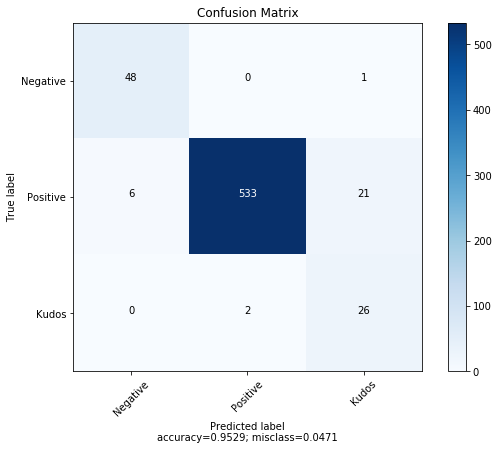

In [76]:
plot_confusion_matrix(matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive', 'Kudos'],
                      title        = "Confusion Matrix")

In [46]:
val.to_excel("output7.xlsx")